In [1]:
import pretty_midi
import IPython
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from DataAPI import MIDI_Dataset, DataAPI, piano_roll_to_pretty_midi
from MidiAPI import MidiAPI
from NetworkAPI import NetworkAPI

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Co trzeba zrobić:
- Miary podobieństwa między utworami (przynajmniej 2-3)
- Przetestowanie różnych architektur sieci i ich ewaluacja
- Dodać do instrumentów perkusje w fajny sposób (edycja pliku MidiAPI.py - trochę juz zacząłem)
- Przetesotować, różne długości sekwencji i fps

## Wczytanie datasetu i wybranie wszystkich podstawowych parametrów
- seq_len - długość sekwencji na jakich będzie uczyć się sieć
- fps - ilość dzwięków na sekunde (dokładność konwersji pliku dzwiękowego)
- songs_in_batch - ile utworów wchodzi do jednego losowania batcha
- batch_size - ile sekwencji wchodzi na raz do sieci
- embedding_dim - rozmiar embeddingu w sieci
- hidden_dim - rozmiar warstwy LSTM
- lead - główny instrument generowanego utworu
- path - ścieżka do pliku z plikami .mid i .midi

### Ciekawe leady to:
- Acoustic Bass
- Celesta
- Choir Aahs
- Church Organ
- Drawbar Organ
- FX 1 (rain)
- FX 2 (soundtrack)
- Marimba
- Pad 1 (new age)
- Synth Choir
- Synth Strings 1
- Synth Strings 2
- Taiko Drum
- Vibraphone

In [2]:
seq_len = 30
fps = 1
songs_in_batch = 8
batch_size = 128
embedding_dim = 64
hidden_dim = 64
lead = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
path = './classical_data/'

midi_dataset = MIDI_Dataset(path, fps=fps)
data_api = DataAPI(midi_dataset, songs_in_batch=songs_in_batch, batch_size=batch_size, sequence_length=seq_len)

## Zdefiniowanie architektury sieci

In [3]:
class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, unique_notes, seq_len):
        super().__init__()
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding(unique_notes, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=3, dropout=0.2)
        self.linear = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * seq_len, 512),
            nn.Linear(512, unique_notes))

    def forward(self, x):
        batch_size, _ = x.shape
        embeds = self.embeddings(x)
        lstm_out, _ = self.lstm(embeds.view(self.seq_len, batch_size, -1))
        outputs = self.linear(lstm_out.view(batch_size, -1))
        return outputs

In [4]:
model = LSTM(embedding_dim=embedding_dim, hidden_dim=hidden_dim, unique_notes=data_api.unique_notes_len, seq_len=seq_len)
network_api = NetworkAPI(model, data_api, 'loss_tests', optim.SGD(model.parameters(), lr=0.1))
# network_api.load_checkpoint()

## Trenowanie sieci
- iterations - ilość batchy do przetworzenia
- verbose_every_iteration - show loss every N iterations
- generate_every_iteration - generate new sample every M iterations and append their similarities to:
- network_api.bag_of_words_diffs
- network_api.estimated_tempos

In [5]:
network_api.train_loop(iterations=10000, verbose_every_iteration=1000, generate_every_iteration=500,song_len=100)

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 10000
Learning rate= 0.1
------------------------------------------------
| Iteration:   1 | Time:   3.78s | Loss:  8.21 |
------------------------------------------------
| Iteration: 1001 | Time:  41.92s | Loss:  7.78 |
------------------------------------------------
| Iteration: 2001 | Time:  47.27s | Loss:  7.46 |
------------------------------------------------
| Iteration: 3001 | Time:  53.21s | Loss:  7.70 |
------------------------------------------------
| Iteration: 4001 | Time:  48.30s | Loss:  7.46 |
------------------------------------------------
| Iteration: 5001 | Time:  78.26s | Loss:  7.47 |
------------------------------------------------
| Iteration: 6001 | Time:  43.46s | Loss:  7.43 |
------------------------------------------------
| Iteration: 7001 | Time:  52.77s | Loss:  7.81 |
------------------------------------------------
| Iteration: 8001 | Time:  51.66s | Loss:  6.98 |
-----------------------

## Analiza zbieżnośi 
Badanie podobieństwa między generowanymi utworami a datasetem
### Badanie zbieżności tempa utworu 
- powinno zbiegać do czerwonej lini

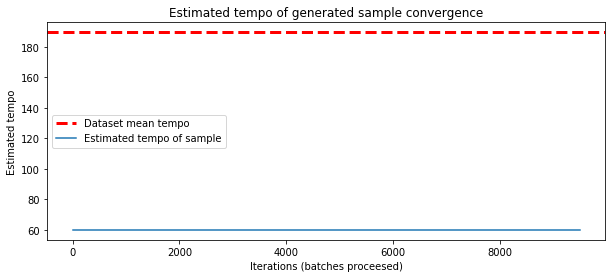

In [6]:
network_api.plot_estimated_tempo_diff()

### Badanie zbieżności częstości występowania nut
- powinno zbiegać do zera

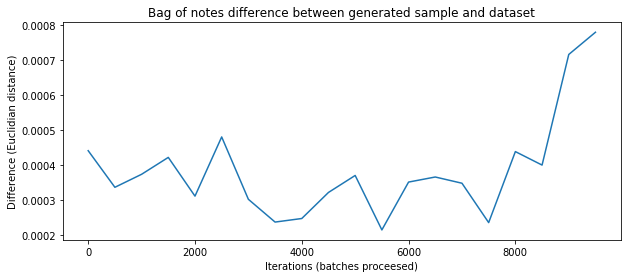

In [7]:
network_api.plot_bag_of_words_diff()

### Analiza zwykłego loss przy problemie klasyfikacji
- powinno zbiegać do zera
- Jeżeli jest więcej niż 10 000 iteracji, wykres jest uśredniony co 1000 iterację
- Jeżeli jest mniej niż 10 000 iteracji loss jest wyplotowany bezpośrednio

C:\Anaconda\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


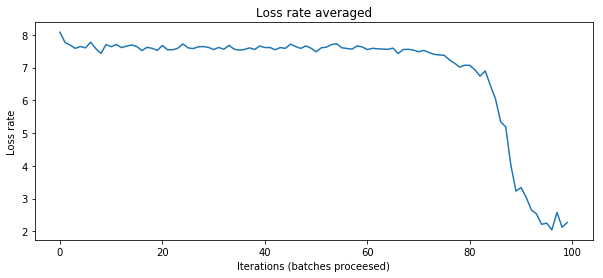

In [8]:
network_api.plot_errors()

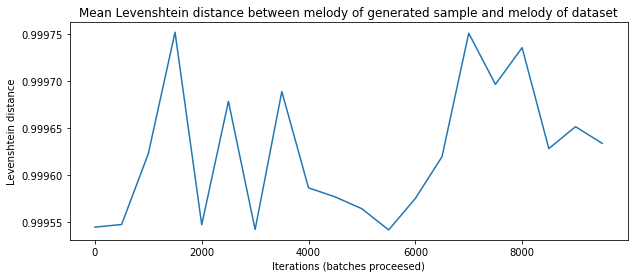

In [9]:
network_api.plot_mean_levenshtain_distance()

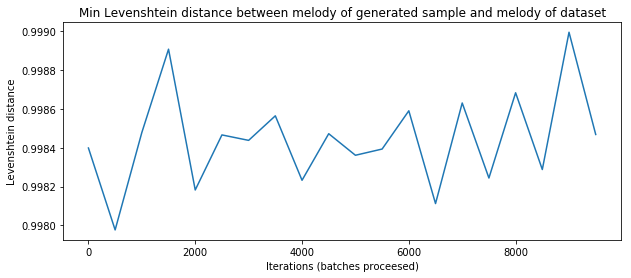

In [10]:
network_api.plot_min_levenshtain_distance()

## Wygenerowanie sampla z naszej sieci 
- song_len - długość wygenerowanego utworu (w sekundach)
- temperature - coś z paczki pretty midi
- program - rodzaj instrumentu

In [31]:
sample_midi = network_api.generate_sample_midi(song_len = 180, temperature = 1.0, program = lead)
sample_midi.write('./first_sample.mid')

Na piano rollu będziemy badać podobieństwa między utworami, więc ta funkcja z prettyMIDI jest dosyć ważna

In [32]:
sample_midi.get_piano_roll()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Testowy odsłuch utworu
- na bardzo brzydkim instrumencie - lepiej odpalić plik .midi w Windows Media Player, albo dowolnym innym odtwarzaczu, który obsługuje ten format

In [33]:
IPython.display.Audio(sample_midi.synthesize(fs=8000), rate=8000)

## Wykres Piano Roll wygenerowanego utworu

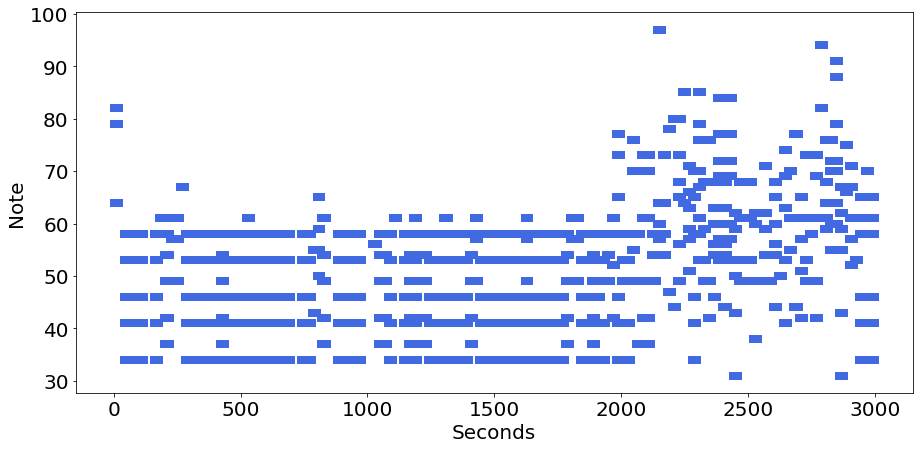

In [27]:
midi_api = MidiAPI(midi = sample_midi)
midi_api.plot_piano_roll()

## Porównanie Piano Rolla wygenerowanego utworu z przykłądowym z training setu
- jeszcze nie działa tak jak trzeba

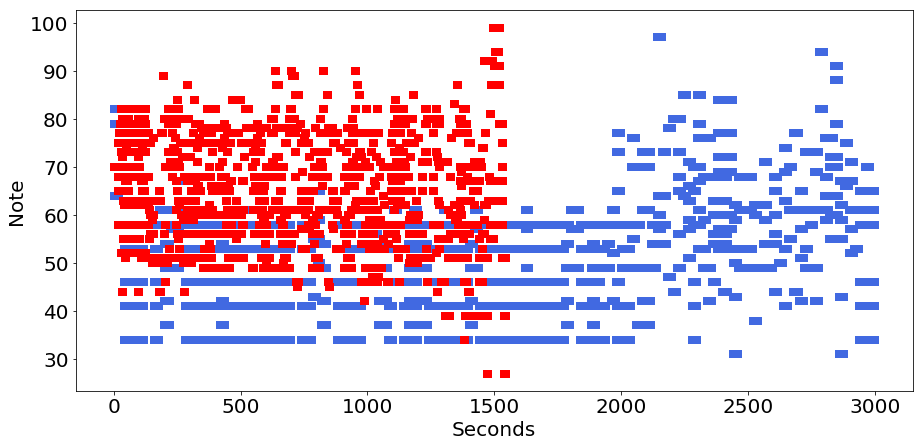

In [29]:
training_midi = pretty_midi.PrettyMIDI('./classical_data/chp_op18.mid')
midi_api.compare_piano_rolls(training_midi, fps)